In [15]:
MODELS_CONFIG = {
    'faster_rcnn_r50_fpn_1x': {
        'config_file': 'configs/pascal_voc/faster_rcnn_r50_fpn_1x_voc0712.py'
    },
    'cascade_rcnn_r50_fpn_1x': {
        'config_file': 'configs/cascade_rcnn_r50_fpn_1x.py',
    },
    'retinanet_r50_fpn_1x': {
        'config_file': 'configs/retinanet_r50_fpn_1x.py',
    }
}

In [16]:
git_repo_url = 'https://github.com/derejetabzaw/mmdetection_object_detection_demo.git'
selected_model = 'faster_rcnn_r50_fpn_1x'  

# Total training epochs.
total_epochs = 8

# Name of the config file.
config_file = MODELS_CONFIG[selected_model]['config_file']



In [17]:
import os
from os.path import exists, join, basename, splitext
%cd /content
project_name = os.path.abspath(splitext(basename(git_repo_url))[0])
mmdetection_dir = os.path.join(project_name, "mmdetection")



if not exists(project_name):
    !git clone -q --recurse-submodules --depth 1 $git_repo_url
    print("Update mmdetection repo")
    !cd {mmdetection_dir} && git checkout master && git pull
    #dependencies
    !pip install -q mmcv terminaltables
    # #build
    !cd {mmdetection_dir} && python setup.py install
    !pip install -r {os.path.join(mmdetection_dir, "requirements.txt")}


import sys
sys.path.append(mmdetection_dir)
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

/content


In [18]:
!cd {mmdetection_dir} && git config --global user.email "derejetabzaw@gmail.com" && git config --global user.name "Dereje" && git stash

Saved working directory and index state WIP on (no branch): 85eae630 batchsize , epochs


In [19]:
%cd {project_name}
!git pull --recurse-submodules

/content/mmdetection_object_detection_demo
Fetching submodule mmdetection
Already up to date.


In [20]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET

In [21]:
anno_path = os.path.join(project_name, "data/VOC2007/Annotations")
voc_file = os.path.join(mmdetection_dir, "mmdet/datasets/voc.py")

In [22]:
classes_names = []
xml_list = []
for xml_file in glob.glob(anno_path + "/*.xml"):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall("object"):
        classes_names.append(member[0].text)
classes_names = list(set(classes_names))
classes_names.sort()
classes_names

['Column',
 'Column_data',
 'Data_Vgroup',
 'Data_group',
 'Header_Title',
 'Table_Headers',
 'Table_headers']

In [23]:
import re

fname = voc_file
with open(fname) as f:
    s = f.read()
    s = re.sub('CLASSES = \(.*?\)',
               'CLASSES = ({})'.format(", ".join(["\'{}\'".format(name) for name in classes_names])), s, flags=re.S)
with open(fname, 'w') as f:
    f.write(s)
!cat {voc_file}

# Copyright (c) OpenMMLab. All rights reserved.
from collections import OrderedDict

from mmcv.utils import print_log

from mmdet.core import eval_map, eval_recalls
from .builder import DATASETS
from .xml_style import XMLDataset


@DATASETS.register_module()
class VOCDataset(XMLDataset):

    CLASSES = ('Column', 'Column_data', 'Data_Vgroup', 'Data_group', 'Header_Title', 'Table_Headers', 'Table_headers')

    PALETTE = [(106, 0, 228), (119, 11, 32), (165, 42, 42), (0, 0, 192),
               (197, 226, 255), (0, 60, 100), (0, 0, 142), (255, 77, 255),
               (153, 69, 1), (120, 166, 157), (0, 182, 199), (0, 226, 252),
               (182, 182, 255), (0, 0, 230), (220, 20, 60), (163, 255, 0),
               (0, 82, 0), (3, 95, 161), (0, 80, 100), (183, 130, 88)]

    def __init__(self, **kwargs):
        super(VOCDataset, self).__init__(**kwargs)
        if 'VOC2007' in self.img_prefix:
            self.year = 2007
        elif 'VOC2012' in self.img_prefix:
            self.year

In [24]:
import os
config_fname = os.path.join(project_name, 'mmdetection', config_file)
assert os.path.isfile(config_fname), '`{}` not exist'.format(config_fname)


In [25]:
fname = config_fname
with open(fname) as f:
    s = f.read()
    work_dir = re.findall(r"work_dir = \'(.*?)\'", s)
    # Update `num_classes` including `background` class.
    s = re.sub('num_classes=.*?,',
               'num_classes={},'.format(len(classes_names) + 1), s)
    s = re.sub('ann_file=.*?\],',
               "ann_file=data_root + 'VOC2007/ImageSets/Main/trainval.txt',", s, flags=re.S)
    s = re.sub('total_epochs = \d+',
               'total_epochs = {} #'.format(total_epochs), s)
    if "CocoDataset" in s:
        s = re.sub("dataset_type = 'CocoDataset'",
                   "dataset_type = 'VOCDataset'", s)
        s = re.sub("data_root = 'data/coco/'",
                   "data_root = 'data/VOCdevkit/'", s)
        s = re.sub("annotations/instances_train2017.json",
                   "VOC2007/ImageSets/Main/trainval.txt", s)
        s = re.sub("annotations/instances_val2017.json",
                   "VOC2007/ImageSets/Main/test.txt", s)
        s = re.sub("annotations/instances_val2017.json",
                   "VOC2007/ImageSets/Main/test.txt", s)
        s = re.sub("train2017", "VOC2007", s)
        s = re.sub("val2017", "VOC2007", s)
    else:
        s = re.sub('img_prefix=.*?\],',
                   "img_prefix=data_root + 'VOC2007/',".format(total_epochs), s)
with open(fname, 'w') as f:
    f.write(s)
!cat {config_fname}

_base_ = [
    '../_base_/models/faster_rcnn_r50_fpn.py', '../_base_/datasets/voc0712.py',
    '../_base_/default_runtime.py'
]
model = dict(roi_head=dict(bbox_head=dict(num_classes=7)))
# optimizer
optimizer = dict(type='AdamW', lr=0.001, weight_decay=0.0001)
optimizer_config = dict(grad_clip=None)
# learning policy
# actual epoch = 3 * 3 = 9
lr_config = dict(policy='step', step=[3])
# runtime settings
runner = dict(
    type='EpochBasedRunner', max_epochs=1000)  # actual epoch = 4 * 3 = 12


In [26]:
%cd {mmdetection_dir}
!python setup.py install

/content/mmdetection_object_detection_demo/mmdetection
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
running install
running bdist_egg
running egg_info
writing mmdet.egg-info/PKG-INFO
writing dependency_links to mmdet.egg-info/dependency_links.txt
writing requirements to mmdet.egg-info/requires.txt
writing top-level names to mmdet.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'mmdet.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
copying mmdet/datasets/voc.py -> build/lib/mmdet/datasets
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mmdet
creating build/bdist.linux-x86_64/egg/mmdet/utils
copying build/lib/mmdet/utils/profiling.py -> build/bdist.linux-x86_64/egg/mmdet/utils
copying build/lib/mmdet/utils/split_batch.py -> build/bdist.linux-x86_64/egg/mmdet/utils
copying build/lib/mmdet/utils/util_random.py -> bu

In [27]:
os.makedirs("data/VOCdevkit", exist_ok=True)
voc2007_dir = os.path.join(project_name, "data/VOC2007")
os.system("ln -s {} data/VOCdevkit".format(voc2007_dir))

256

In [ ]:
!python tools/train.py {config_fname}

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
/usr/local/lib/python3.7/dist-packages/mmdet-2.25.1-py3.7.egg/mmdet/utils/setup_env.py:39: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
/usr/local/lib/python3.7/dist-packages/mmdet-2.25.1-py3.7.egg/mmdet/utils/setup_env.py:49: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '
2022-08-10 07:53:46,827 - mmdet - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.7.13 (default, Apr 24 2022, 

In [ ]:
# pip install  mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.8.0/index.html

In [3]:
checkpoint_file = os.path.join(mmdetection_dir, "./work_dirs/faster_rcnn_r50_fpn_1x_voc0712/", "latest.pth")
assert os.path.isfile(
    checkpoint_file), '`{}` not exist'.format(checkpoint_file)
checkpoint_file

NameError: ignored

In [ ]:
#  !pip install --upgrade mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111}/torch1.8.0/index.html
# !pip install terminaltables

In [ ]:
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

import mmcv
from mmcv.runner import load_checkpoint
import mmcv.visualization.image as mmcv_image
# fix for colab


def imshow(img, win_name='', wait_time=0): plt.figure(
    figsize=(50, 50)); plt.imshow(img)


mmcv_image.imshow = imshow
from mmdet.models import build_detector
from mmdet.models.detectors import BaseDetector
from mmdet.apis import inference_detector, init_detector
from mmcv.image.io import imread

In [ ]:
%cd {mmdetection_dir}

score_thr = 0.8

# build the model from a config file and a checkpoint file
model = init_detector(config_fname, checkpoint_file)
# test a single image and show the results
img = os.path.join(mmdetection_dir, "data/VOCdevkit/VOC2007/JPEGImages/174.jpg")
# img = '/content/mmdetection_object_detection_demo/mmdetection/data/VOCdevkit/VOC2007/JPEGImages/15.jpg'
result = inference_detector(model, img)
# imshow(img)
img = imread(img)

BaseDetector.show_result(img=img, result=result, self=model, show=True, score_thr=score_thr, out_file="result.jpg")


/content/mmdetection_object_detection_demo/mmdetection
load checkpoint from local path: /content/mmdetection_object_detection_demo/mmdetection/./work_dirs/faster_rcnn_r50_fpn_1x_voc0712/latest.pth


In [ ]:
# !python mmdet/utils/collect_env.py

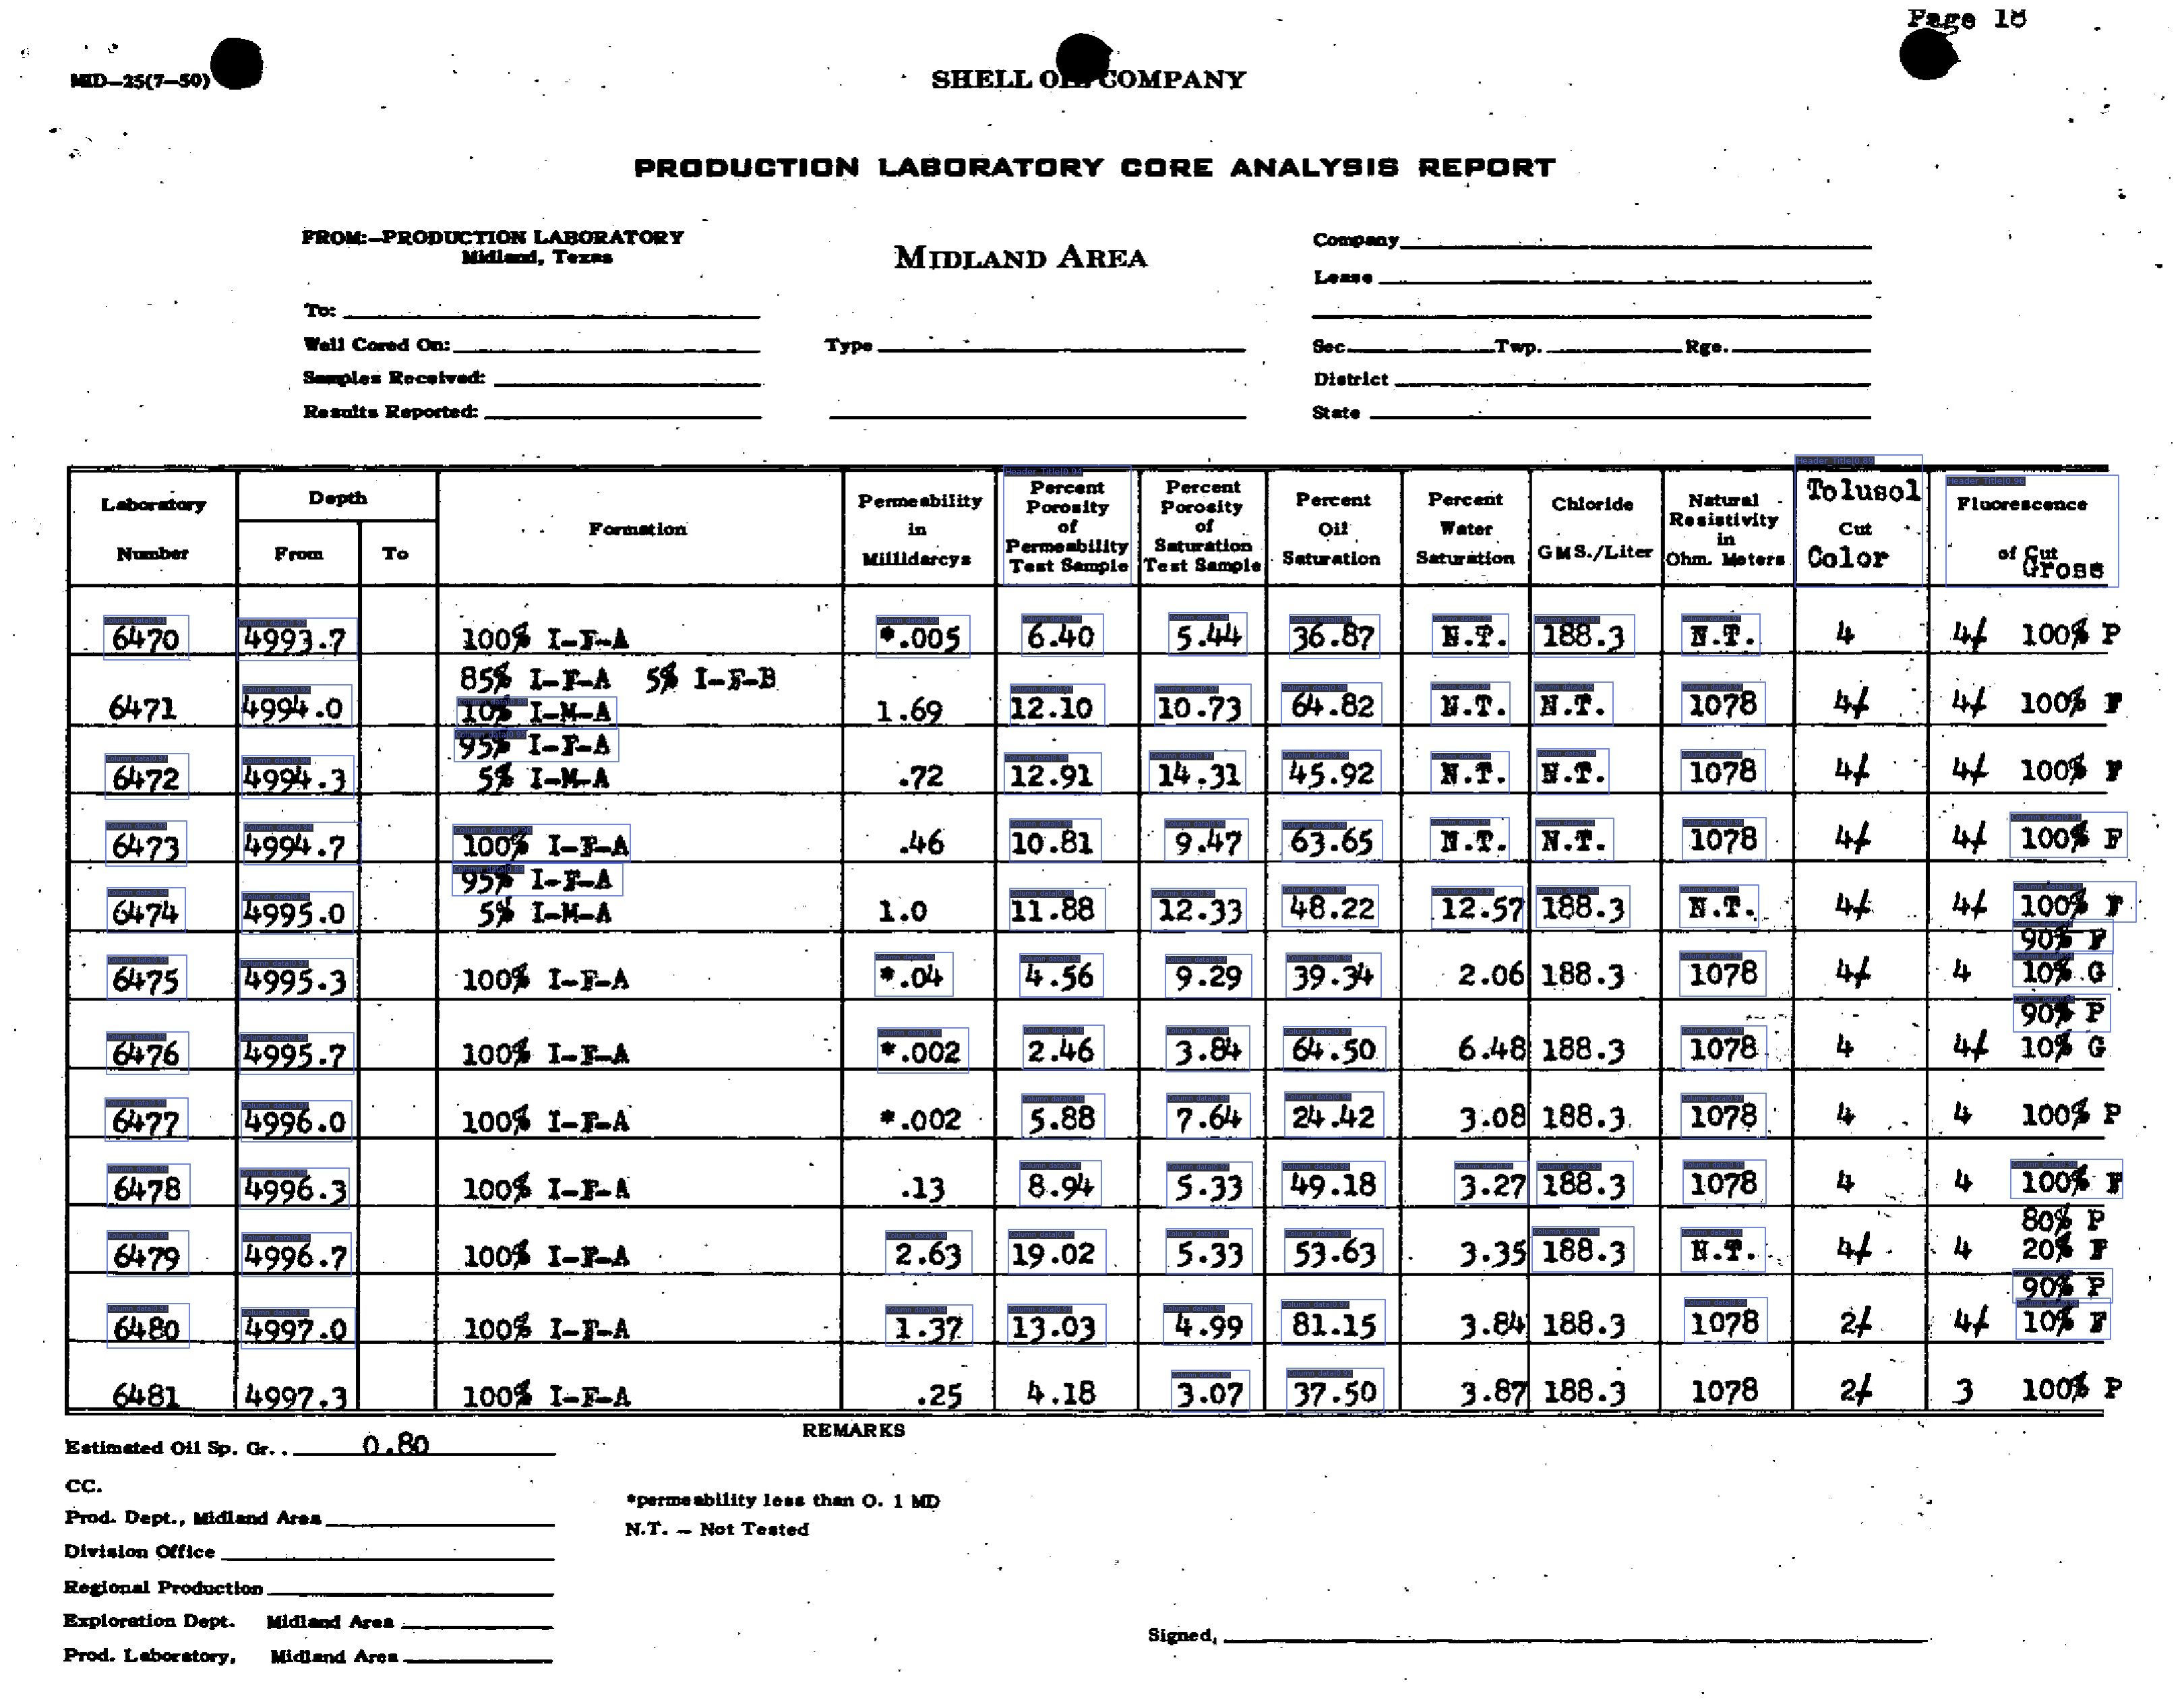

In [ ]:
from IPython.display import Image
Image(filename='result.jpg')

In [ ]:
# !pip install -U torchvision==0.4.

In [ ]:
# import torch, mmcv, mmdet


In [ ]:
# !pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

In [ ]:
#  !pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10/index.html

In [ ]:
# !pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu92/torch1.7.0/index.html

In [ ]:
# !pip uninstall torch

In [ ]:
# !pip uninstall mmcv-full

In [ ]:
# !pip install mmdet==2.3.0

In [ ]:
# !pip uninstall mmcv-full 

In [ ]:
# !nvcc --version

In [14]:
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.8.0/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 1.4 MB/s eta 0:13:19tcmalloc: large alloc 1147494400 bytes == 0x3a626000 @  0x7fcf53927615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████               | 1055.7 MB 72.1 MB/s eta 0:00:13tcmalloc: large alloc 1434370048 bytes == 0x7ec7c000 @  0x7fcf53927615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████